In [1]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bjdua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bjdua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bjdua\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bjdua\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [3]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})
df["sentimiento"] = df["sentimiento"].map({"FAKE": 0, "REAL": 1})

In [4]:
df.sentimiento.unique()

array([0, 1])

In [5]:
df = df.set_index('Unnamed: 0')

In [6]:
df.shape

(6335, 3)

In [7]:
df.head()

,title,texto,sentimiento
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [8]:
# Contar cuantas noticias reales y fakes hay en el dataset
df["sentimiento"].value_counts()

sentimiento
1    3171
0    3164
Name: count, dtype: int64

- Está balanceado? Cómo lo arreglarías sino?
    Está balanceado por la similar cantidad de datos finales, cerca del 50 - 50. De lo contrario se podría aplicar algo del estilo:


from sklearn.utils import resample

df_fake = df[df["label"] == "FAKE"]
df_real = df[df["label"] == "REAL"]

df_fake_downsampled = resample(df_fake, replace=False, n_samples=len(df_real), random_state=42)
df_balanced = pd.concat([df_fake_downsampled, df_real])

df_balanced["label"].value_counts()

In [9]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?

- Dimensiona el dataset
    Esto se realiza con el df.shape y con df.info() realizado anteriormente
- En término de variable que diferencias encuentras con los que usabas en Machine Learning
    Los datasets en Machine Learning suelen tener variables numéricas como edad, precio, temperatura; variables categóricas discretas como género, tipo de producto; o etiquetas binarias o de multiclase para clasificación.

In [10]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

In [11]:
from sklearn.utils import resample

df_fake = df[df["sentimiento"] == 0]
df_real = df[df["sentimiento"] == 1]

# Reducir cada categoría a 500 muestras aleatorias
df_fake_reduced = resample(df_fake, replace=False, n_samples=500, random_state=42)
df_real_reduced = resample(df_real, replace=False, n_samples=500, random_state=42)

# Combinar en un nuevo dataframe balanceado
df_balanced = pd.concat([df_fake_reduced, df_real_reduced])

# Mezclar aleatoriamente las filas
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar la distribución de clases
print(df_balanced["sentimiento"].value_counts())

sentimiento
1    500
0    500
Name: count, dtype: int64


In [12]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

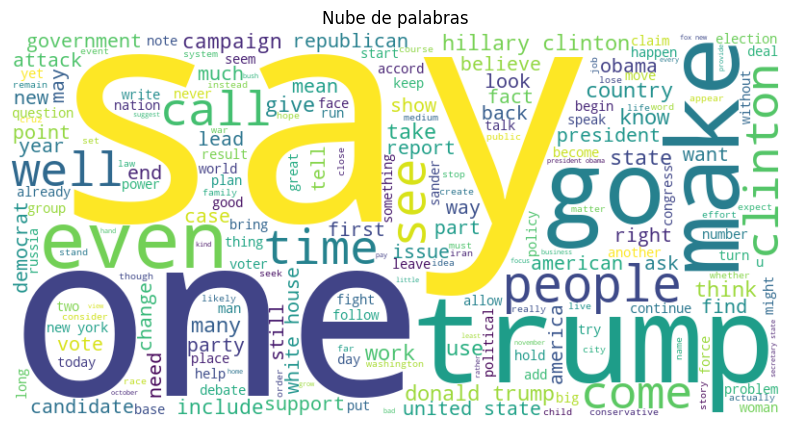

In [13]:
# Aplicar preprocesamiento
df['texto_procesado'] = df['texto'].apply(preprocesar_texto)

# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = " ".join(df['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

Unigramas más comunes:
    N-gram  Frecuencia
0      say       30668
1    trump       22463
2  clinton       17962
3    would       13358
4    state       12829
5      one       12378
6   people       11846
7     make       10469
8       go       10150
9     year       10016


C:\Users\bjdua\AppData\Local\Temp\ipykernel_7220\3877418057.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


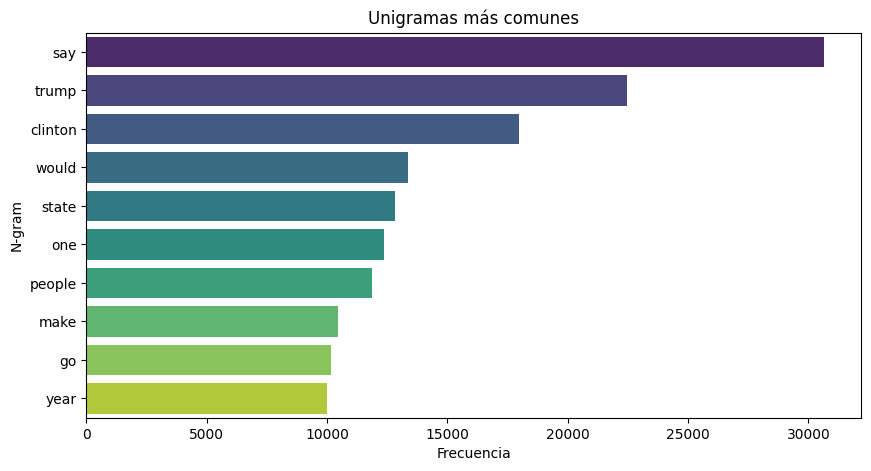


Bigramas más comunes:
            N-gram  Frecuencia
0  hillary clinton        4271
1     donald trump        3814
2    united states        3040
3      white house        2359
4         new york        2229
5  president obama        1249
6         fox news        1225
7  secretary state        1206
8        trump say        1039
9    new hampshire        1006


C:\Users\bjdua\AppData\Local\Temp\ipykernel_7220\3877418057.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


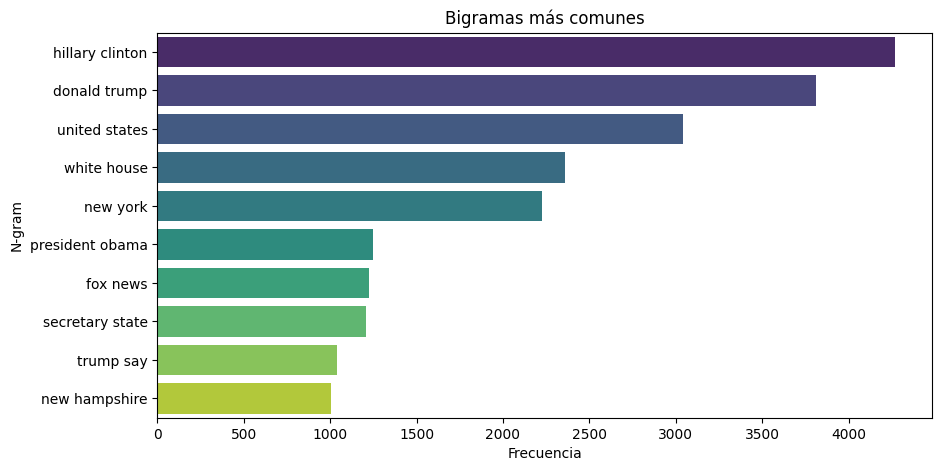

C:\Users\bjdua\AppData\Local\Temp\ipykernel_7220\3877418057.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')



Trigramas más comunes:
                              N-gram  Frecuencia
0                     new york times         604
1             president barack obama         408
2             former secretary state         277
3                       sen ted cruz         274
4            president united states         272
5                wall street journal         230
6  republican presidential candidate         215
7               director james comey         214
8                    sen marco rubio         213
9                      tell fox news         206


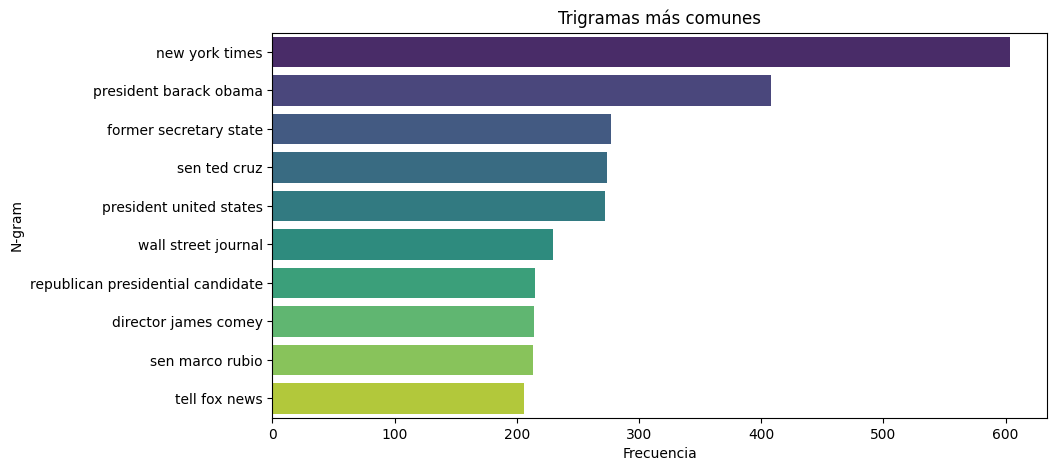

In [14]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df['texto_procesado'], 1)
bigrams = get_top_ngrams(df['texto_procesado'], 2)
trigrams = get_top_ngrams(df['texto_procesado'], 3)
quadgrams = get_top_ngrams(df['texto_procesado'], 4)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

In [15]:
from sklearn.model_selection import train_test_split

# X: texto procesado, y: sentimiento (0 = FAKE, 1 = REAL)
X = df["texto_procesado"]
y = df["sentimiento"]

# División 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizar texto (usar solo entrenamiento para fit)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Accuracy (Logistic Regression): 0.920284135753749

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       633
           1       0.94      0.90      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



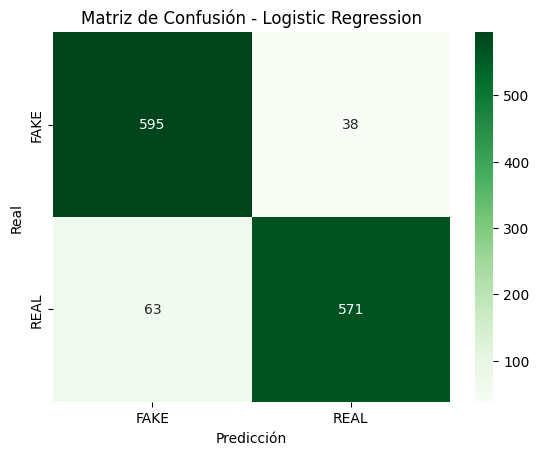


Predicción del ejemplo: FAKE


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Vectorizar
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 2) Entrenar modelo de regresión logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# 3) Evaluar el modelo
y_pred_lr = logreg.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy (Logistic Regression):", accuracy_lr)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_lr))

# 4) Matriz de confusión:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=["FAKE", "REAL"], yticklabels=["FAKE", "REAL"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression")
plt.show()

# 5) Predicción de ejemplo
ejemplo = ["Donald Trump spotted at alien base in Area 51!"]  # <- ejemplo inventado
ejemplo_proc = [preprocesar_texto(e) for e in ejemplo]
ejemplo_vec = vectorizer.transform(ejemplo_proc)
pred_lr = logreg.predict(ejemplo_vec)

print("\nPredicción del ejemplo:", "REAL" if pred_lr[0] == 1 else "FAKE")
